In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data 
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
     
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

In [4]:
def get_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        # 100 x 1 to 4 x 4 x 512
        # 全连接层
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        # batch normalization
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4 x 4 x 512 to 7 x 7 x 256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 256 to 14 x 14 x 128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 14 x 14 x 128 to 28 x 28 x 1
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        # MNIST原始数据集的像素范围在0-1，这里的生成图片范围为(-1,1)
        # 因此在训练时，记住要把MNIST像素范围进行resize
        outputs = tf.tanh(logits)
        
        return outputs

In [5]:
def get_discriminator(inputs_img, reuse=False, alpha=0.01):
    
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 28 x 28 x 1 to 14 x 14 x 128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(inputs_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 14 x 14 x 128 to 7 x 7 x 256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 x 256 to 4 x 4 x 512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4 x 4 x 512 to 4*4*512 x 1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [6]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    
    g_outputs = get_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = get_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, reuse=True)
    
    # 计算Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_outputs_fake)*(1-smooth)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_outputs_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

In [19]:
def get_optimizer(g_loss, d_loss, learning_rate=0.001):
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

In [8]:
def plot_images(samples):
    fig, axes = plt.subplots(nrows=1, ncols=25, sharex=True, sharey=True, figsize=(50,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [9]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪声图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(get_generator(inputs_noise, output_dim, False),
                       feed_dict={inputs_noise: examples_noise})

    
    result = np.squeeze(samples, -1)
    return result

In [10]:
# 定义参数
batch_size = 64
noise_size = 100
epochs = 5
n_samples = 25
learning_rate = 0.001

In [20]:
def train(noise_size, data_shape, batch_size, n_samples):
    
    
    # 存储loss
    losses = []
    steps = 0
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss,learning_rate)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(mnist.train.num_examples//batch_size):
                steps += 1
                batch = mnist.train.next_batch(batch_size)

                batch_images = batch[0].reshape((batch_size, data_shape[1], data_shape[2], data_shape[3]))
                # scale to -1, 1
                batch_images = batch_images * 2 - 1

                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # run optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                
                if steps % 101 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    train_loss_g = g_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))
                                   

Epoch 1/5.... Discriminator Loss: 0.3710.... Generator Loss: 4.4454....
Epoch 1/5.... Discriminator Loss: 0.3656.... Generator Loss: 5.6325....
Epoch 1/5.... Discriminator Loss: 0.4229.... Generator Loss: 6.6512....
Epoch 1/5.... Discriminator Loss: 0.3583.... Generator Loss: 4.9446....
Epoch 1/5.... Discriminator Loss: 0.3684.... Generator Loss: 4.8834....
Epoch 1/5.... Discriminator Loss: 0.3799.... Generator Loss: 5.6147....
Epoch 1/5.... Discriminator Loss: 0.3890.... Generator Loss: 3.9422....
Epoch 1/5.... Discriminator Loss: 0.4076.... Generator Loss: 4.3357....
Epoch 2/5.... Discriminator Loss: 0.4075.... Generator Loss: 4.2236....
Epoch 2/5.... Discriminator Loss: 0.3518.... Generator Loss: 4.9309....
Epoch 2/5.... Discriminator Loss: 0.3813.... Generator Loss: 4.7224....
Epoch 2/5.... Discriminator Loss: 0.5467.... Generator Loss: 5.6015....
Epoch 2/5.... Discriminator Loss: 0.3883.... Generator Loss: 4.4148....
Epoch 2/5.... Discriminator Loss: 0.4195.... Generator Loss: 3.9

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 3/5.... Discriminator Loss: 0.4936.... Generator Loss: 4.9464....
Epoch 3/5.... Discriminator Loss: 0.4148.... Generator Loss: 3.1889....
Epoch 3/5.... Discriminator Loss: 0.4321.... Generator Loss: 5.5335....
Epoch 3/5.... Discriminator Loss: 0.4675.... Generator Loss: 4.9896....
Epoch 3/5.... Discriminator Loss: 0.5596.... Generator Loss: 2.7347....
Epoch 4/5.... Discriminator Loss: 0.5803.... Generator Loss: 2.1847....
Epoch 4/5.... Discriminator Loss: 0.4790.... Generator Loss: 3.0745....
Epoch 4/5.... Discriminator Loss: 0.4438.... Generator Loss: 4.0558....
Epoch 4/5.... Discriminator Loss: 0.4458.... Generator Loss: 3.6056....
Epoch 4/5.... Discriminator Loss: 0.4103.... Generator Loss: 3.5679....
Epoch 4/5.... Discriminator Loss: 0.4686.... Generator Loss: 4.8174....
Epoch 4/5.... Discriminator Loss: 0.4283.... Generator Loss: 4.3951....
Epoch 4/5.... Discriminator Loss: 0.5311.... Generator Loss: 2.4714....
Epoch 4/5.... Discriminator Loss: 0.4687.... Generator Loss: 3.0

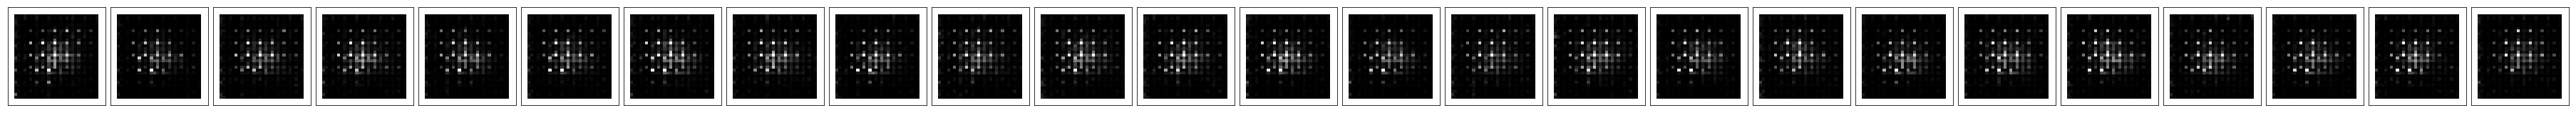

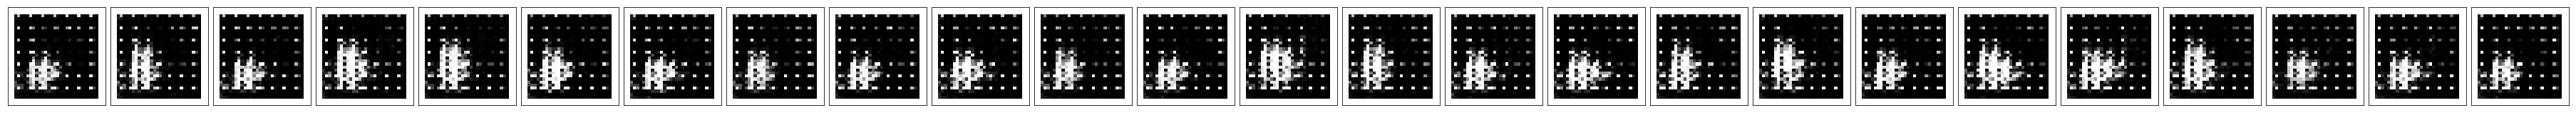

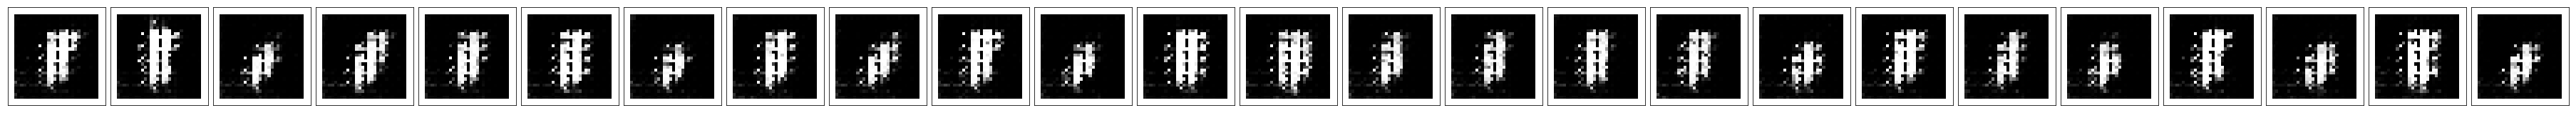

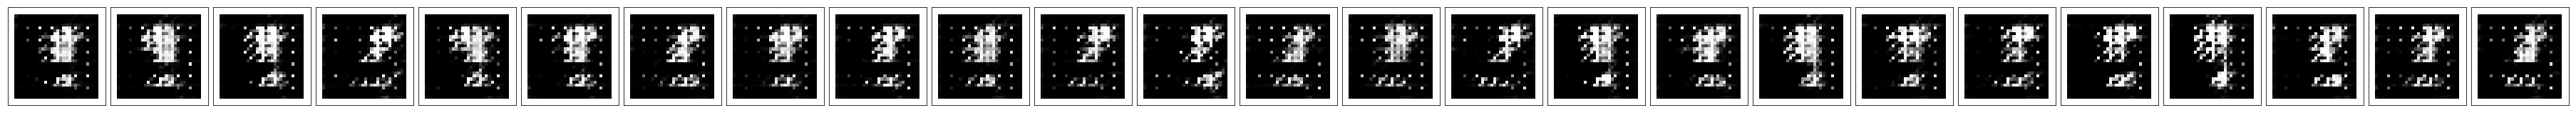

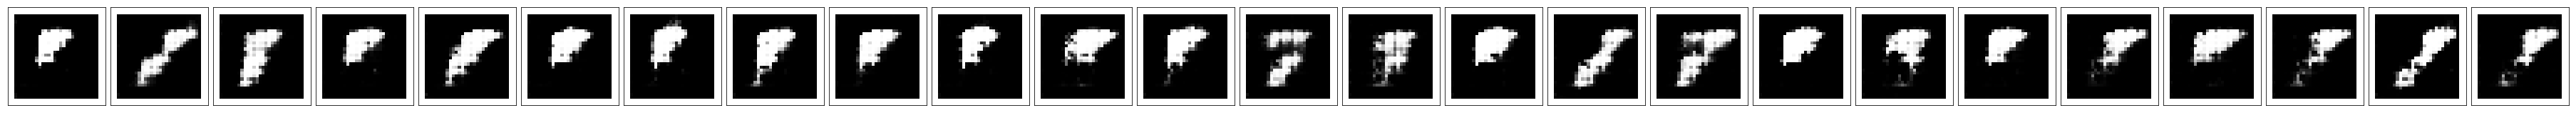

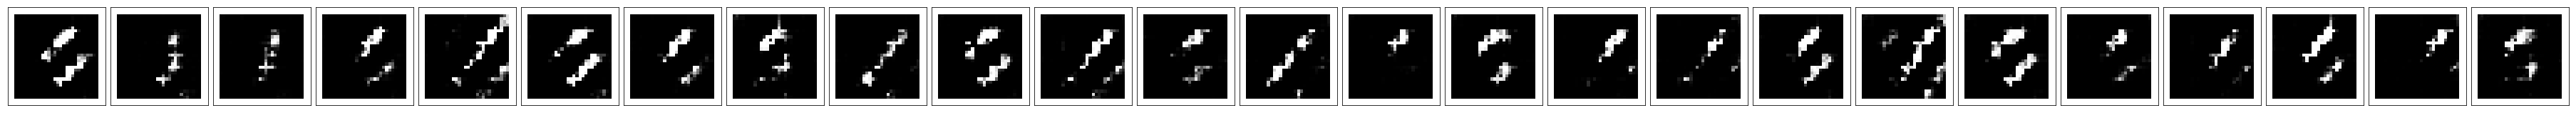

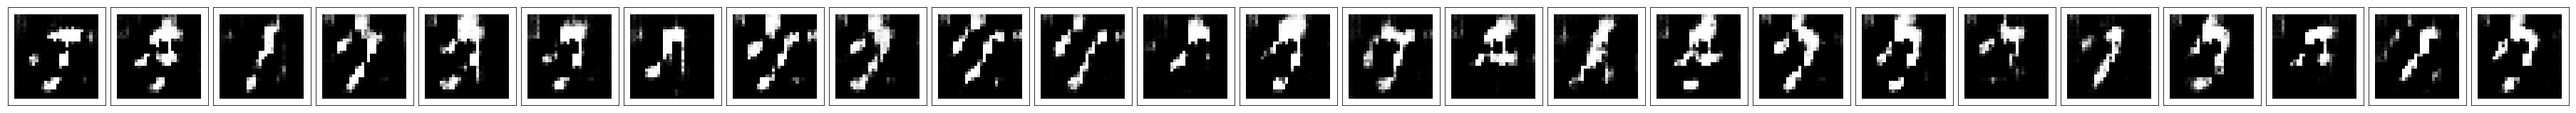

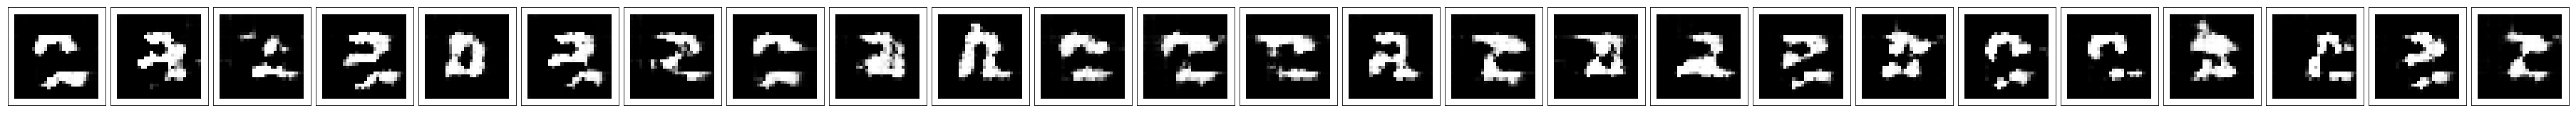

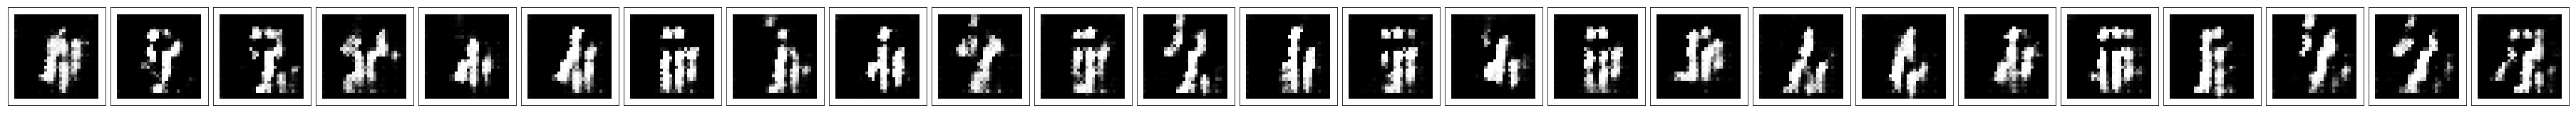

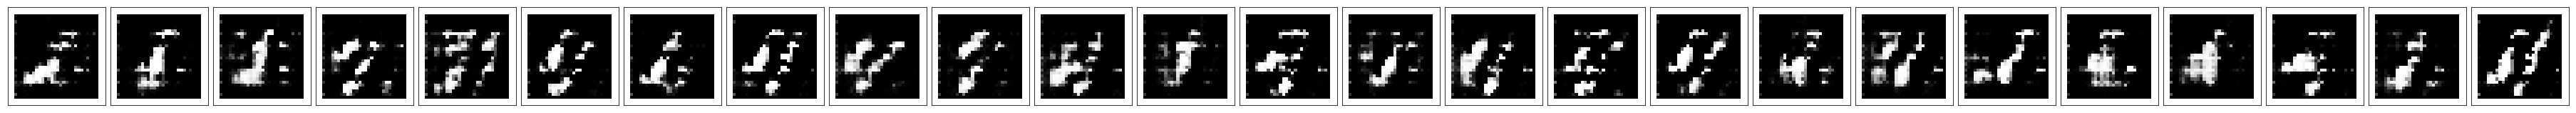

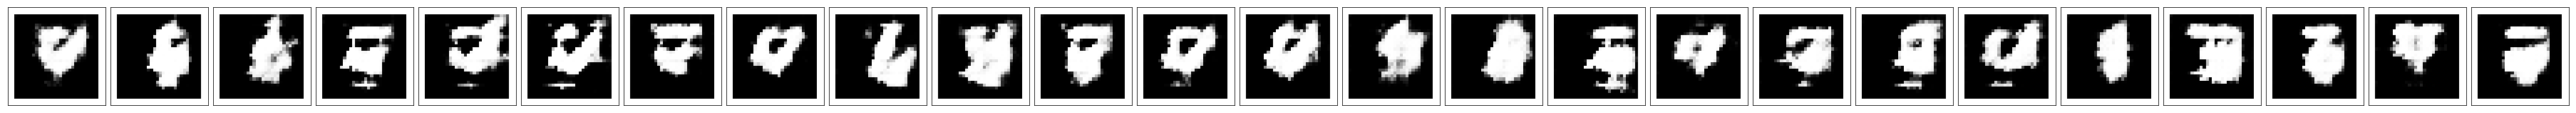

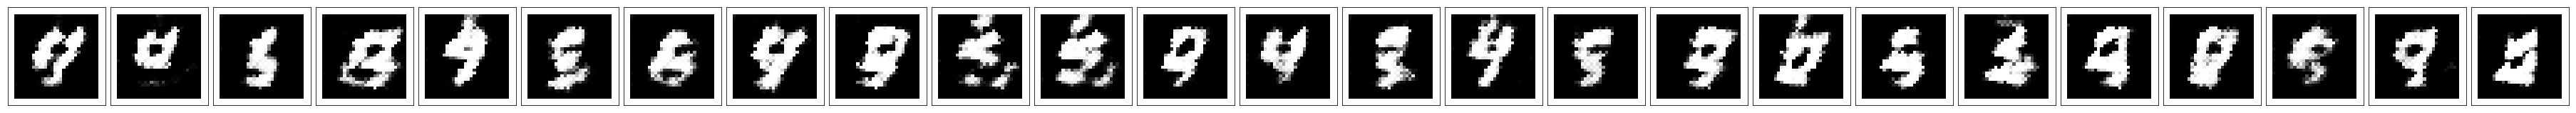

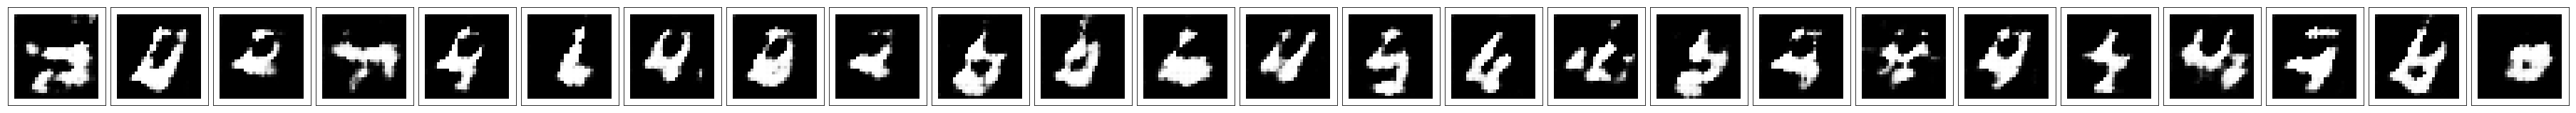

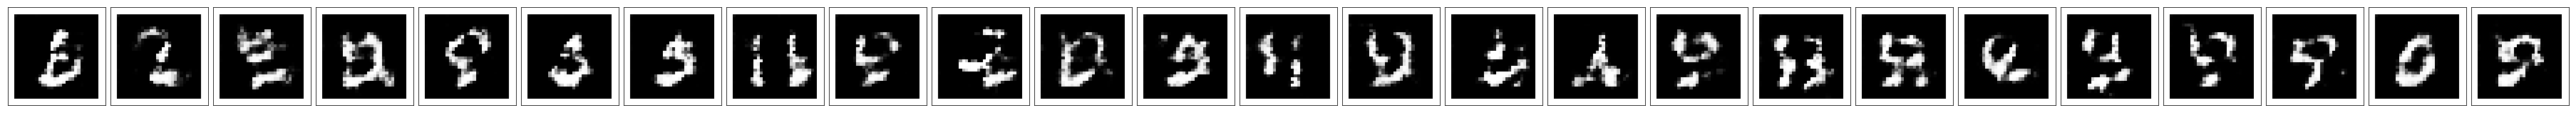

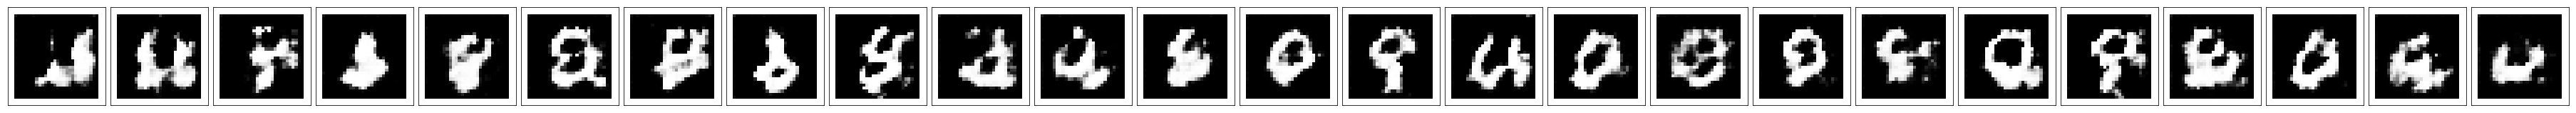

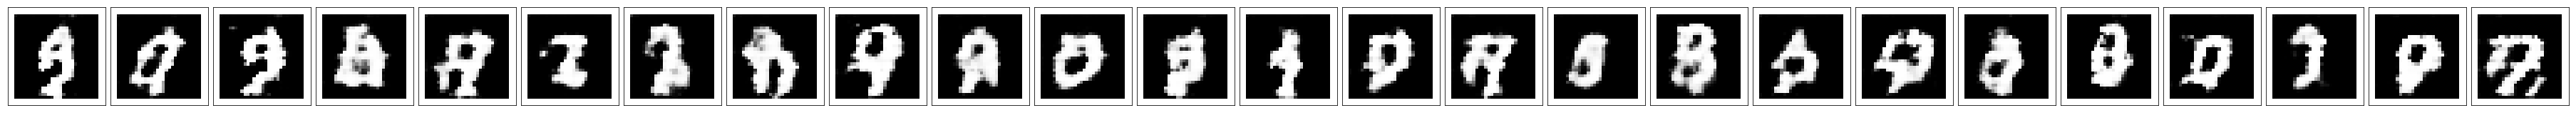

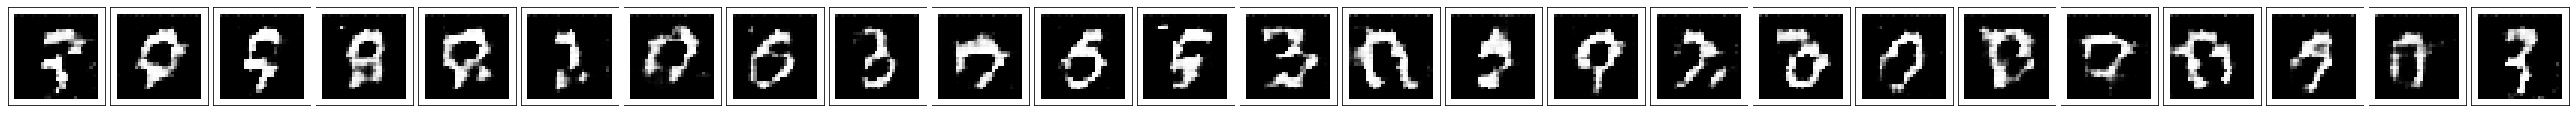

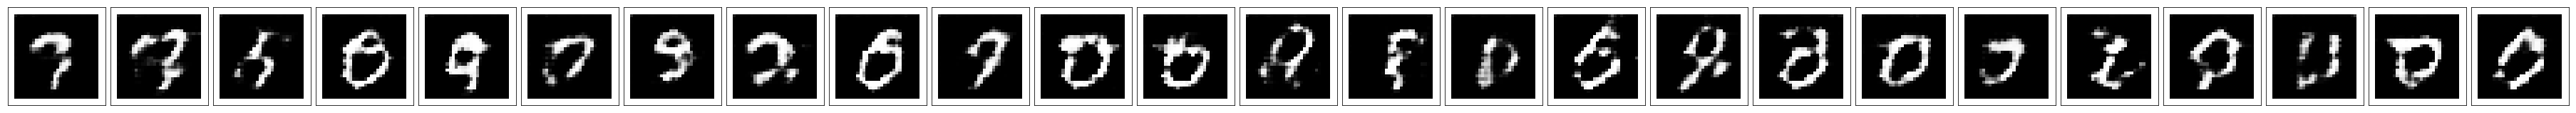

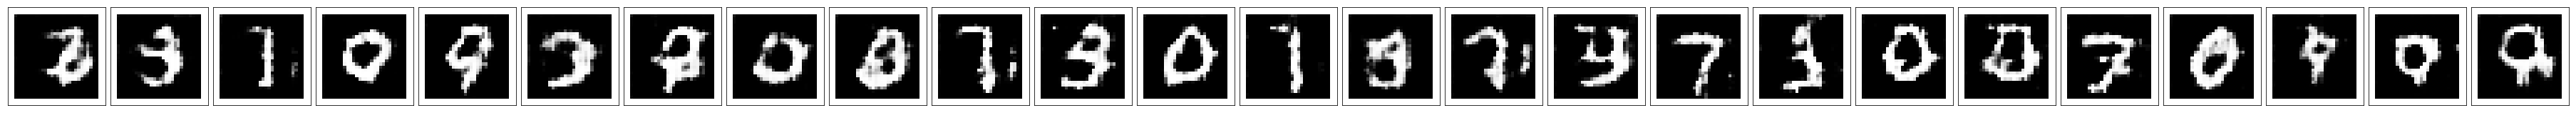

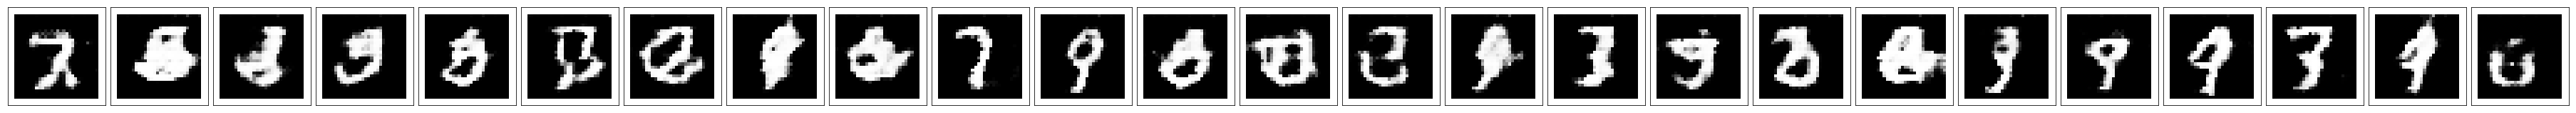

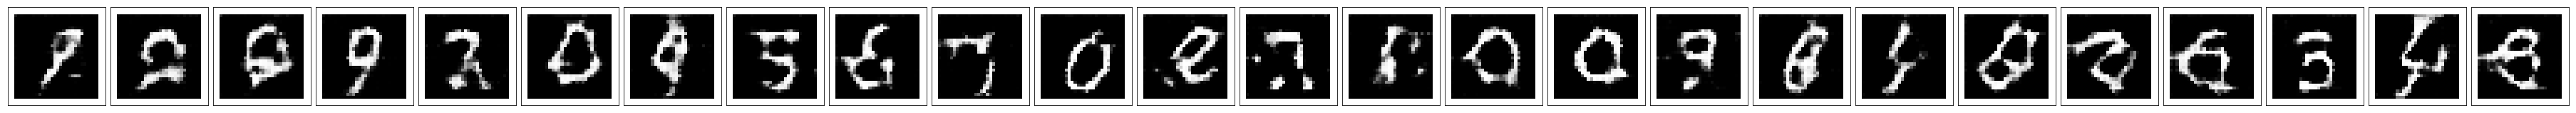

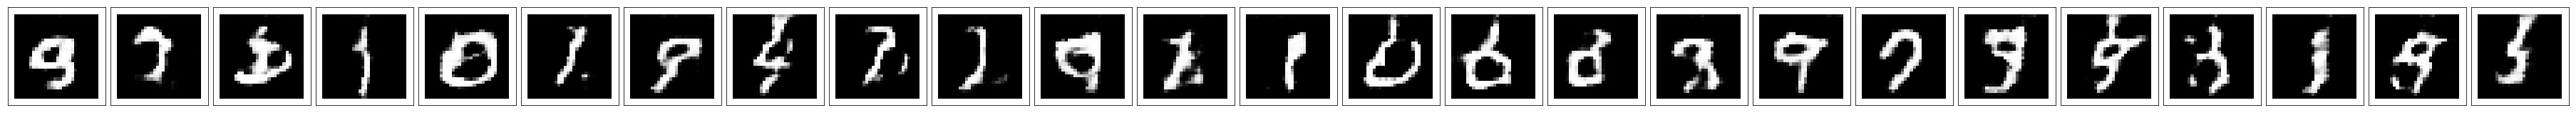

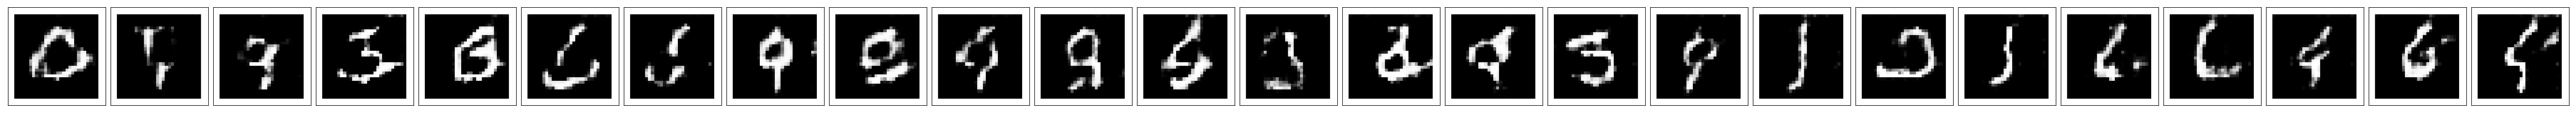

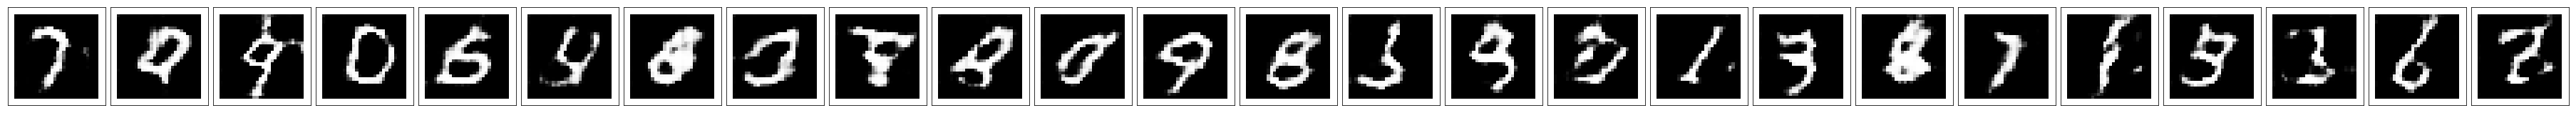

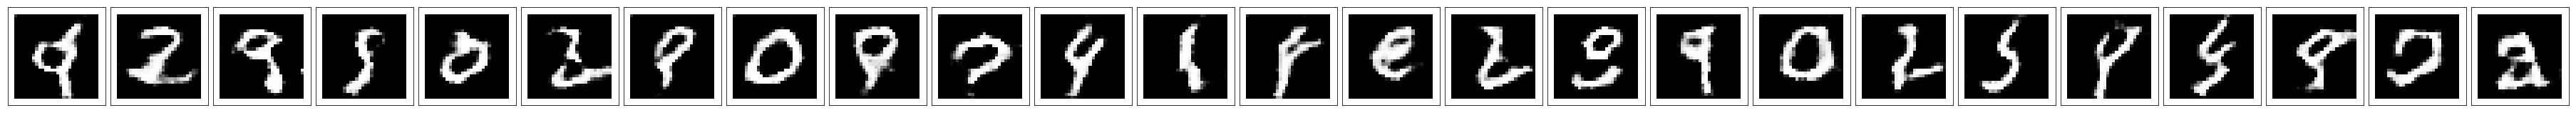

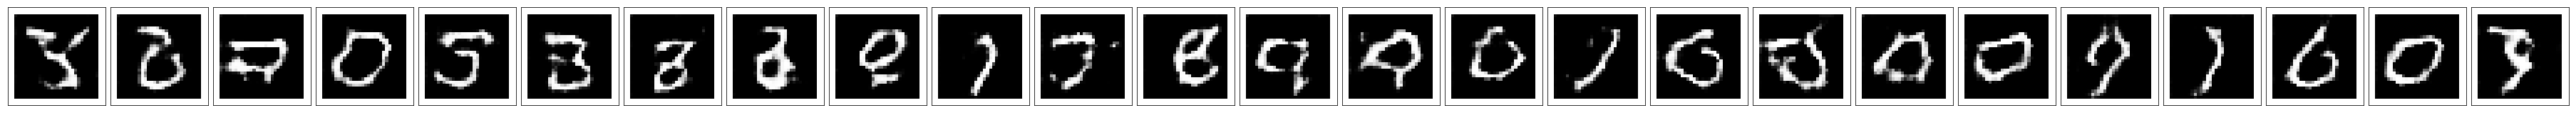

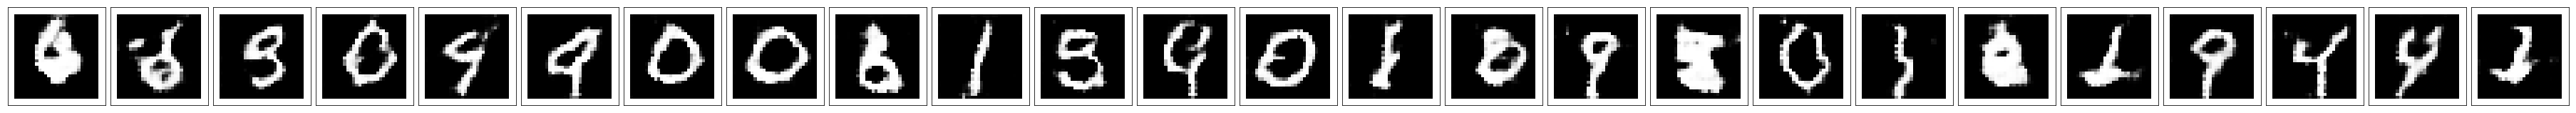

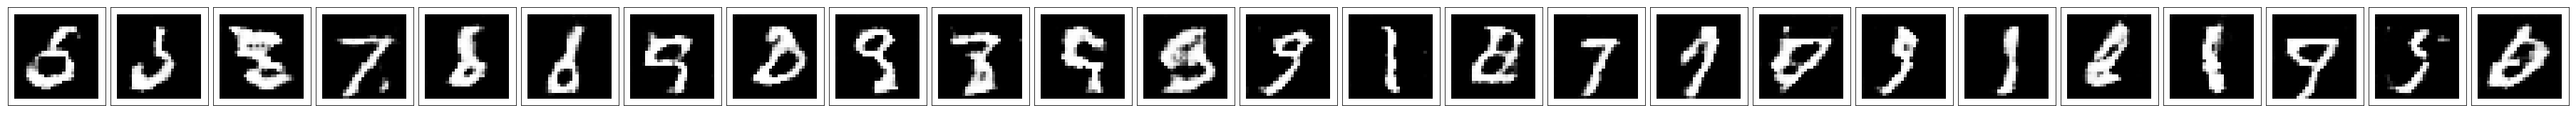

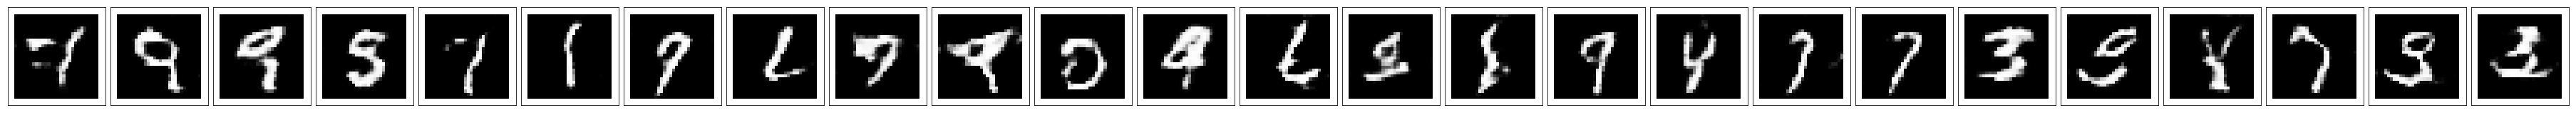

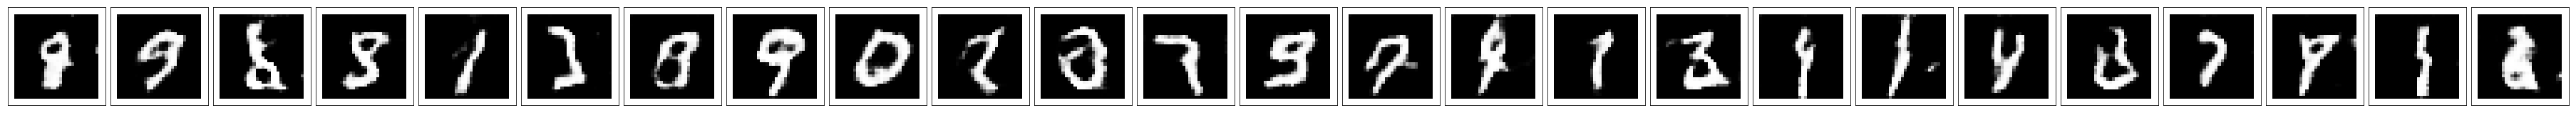

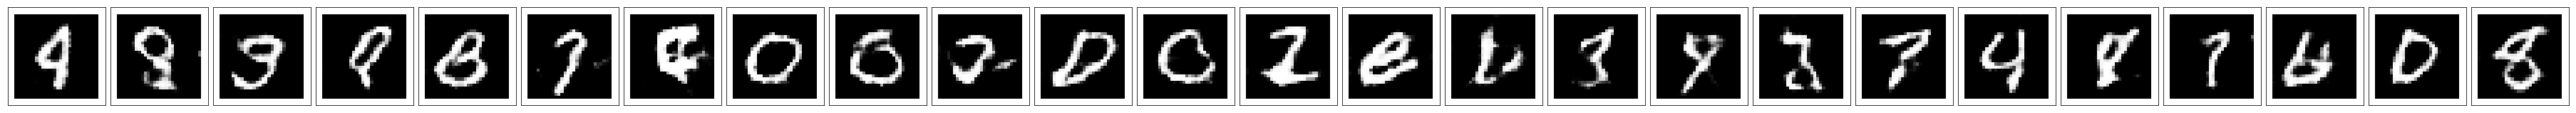

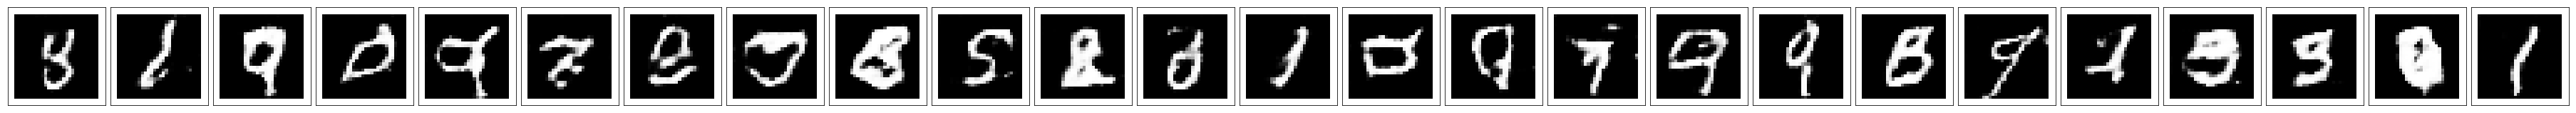

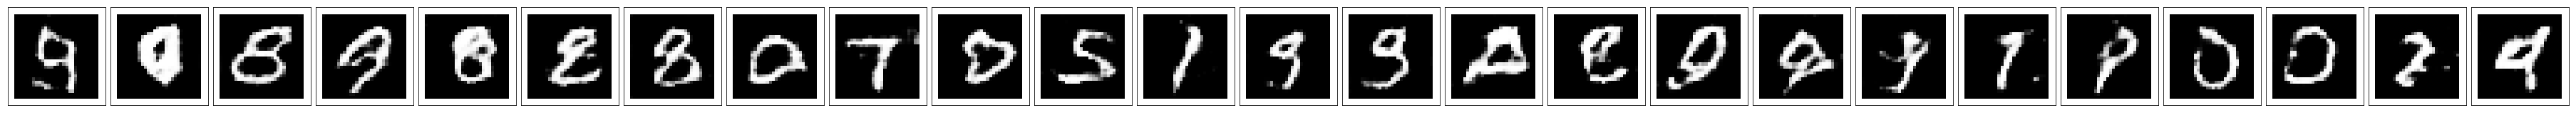

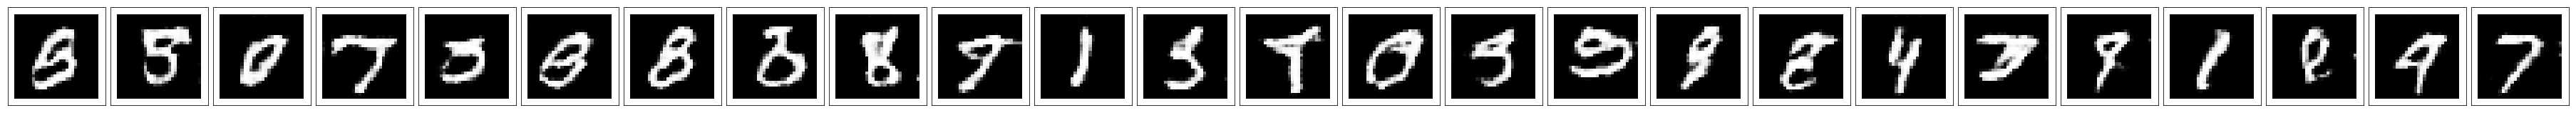

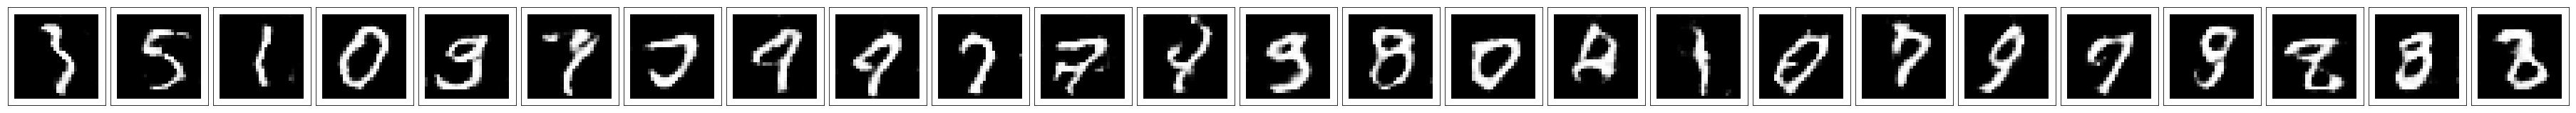

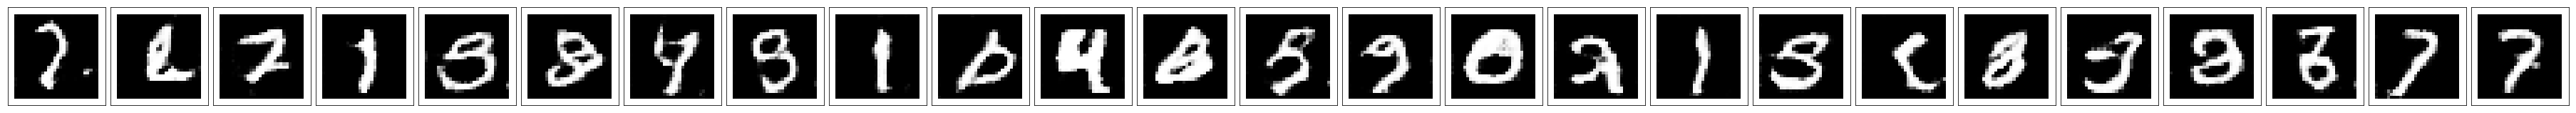

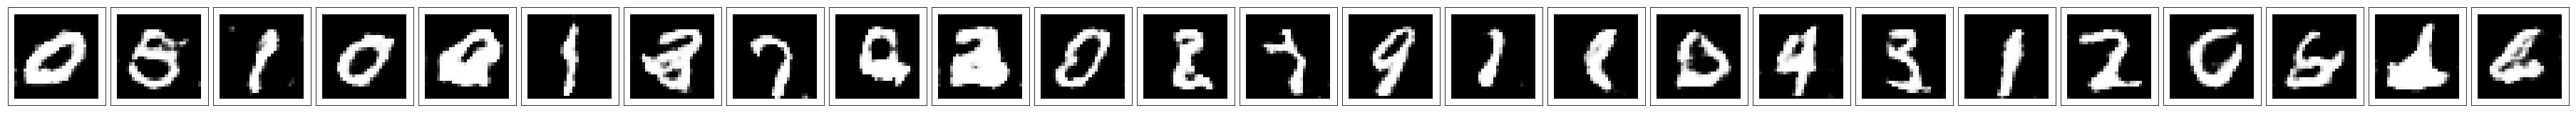

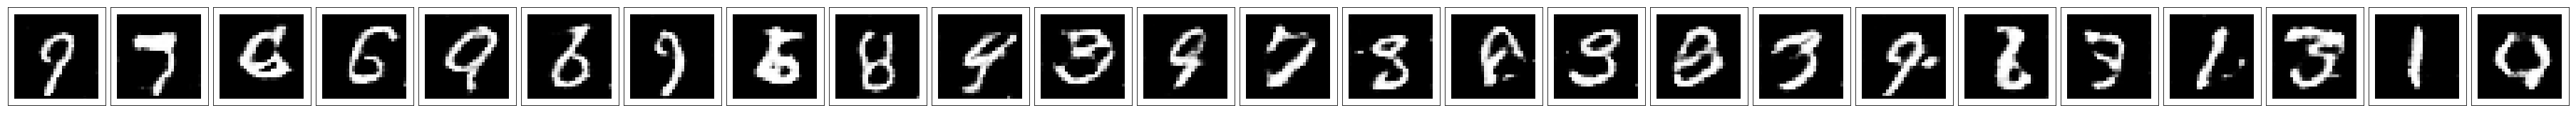

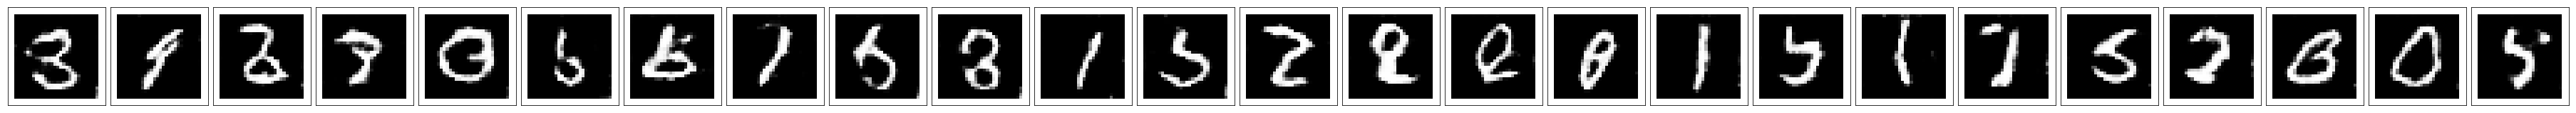

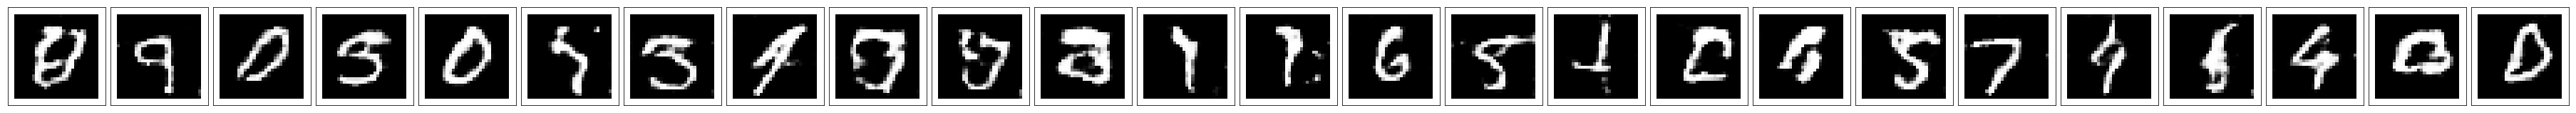

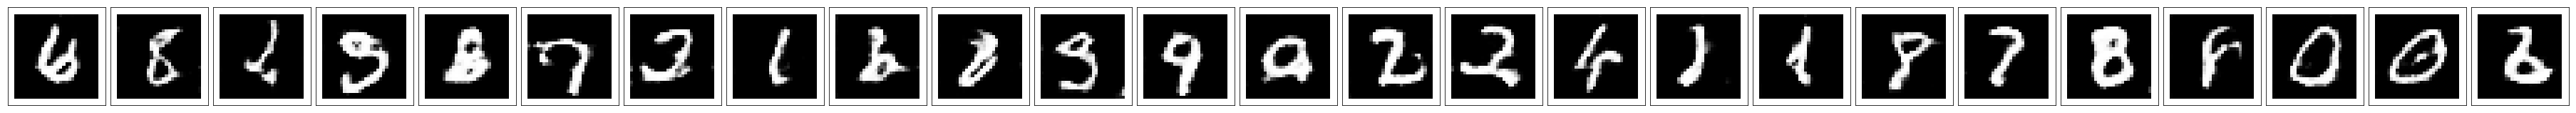

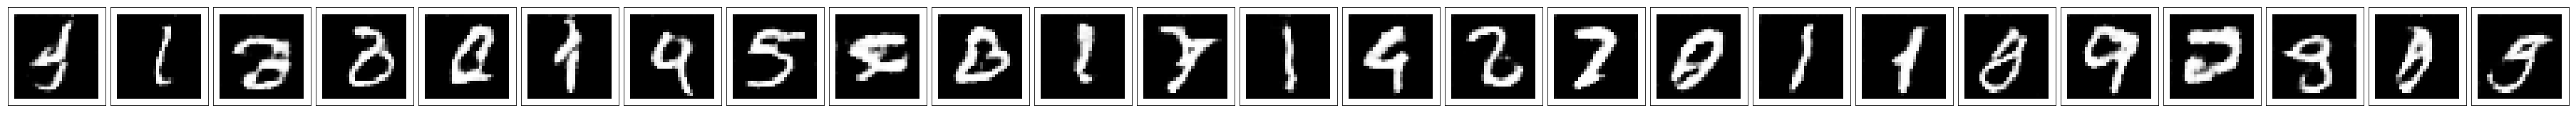

In [21]:
with tf.Graph().as_default():
    train(noise_size, [-1, 28, 28, 1], batch_size, n_samples)